In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns

import analytical_solution as anso
import functions as fu

In [2]:
#### INPUT PARAMETERS ####
N = 1000
omega = 1
L = 5
k = 16

In [3]:
#### VARIABLES NEEDED TO BE COMPUTED ####
deltax = (2*L)/N
x_i = np.array([(((2*L)/N)*i - L) for i in range(N)])

## Functions

## Analytical

In [4]:
eigenvalues_analy, eigenvectors_analy = anso.analytic_eigenv(x_i, omega, k)

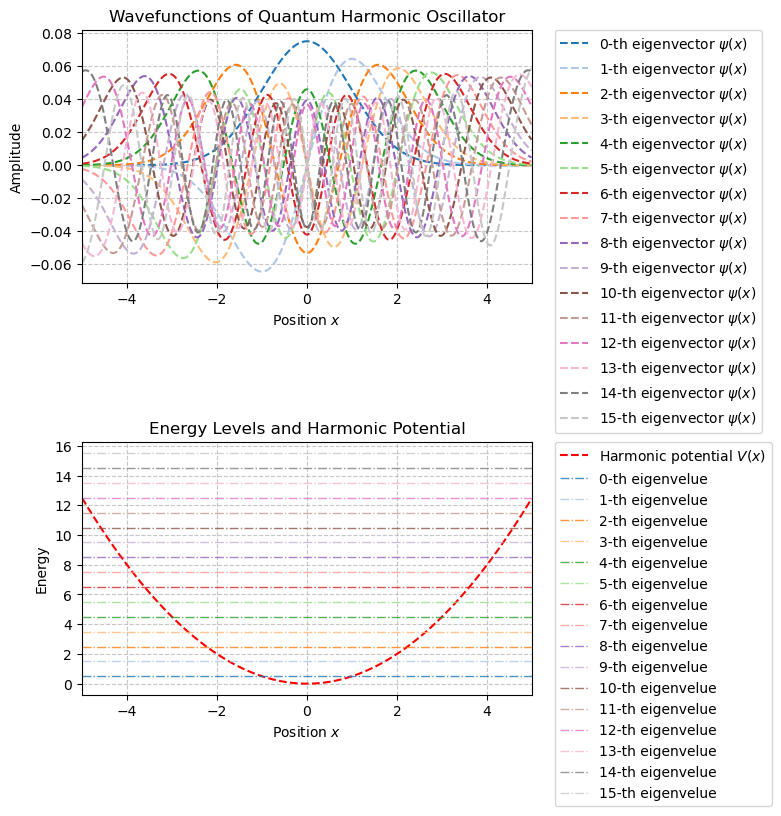

In [5]:
fu.plot(k, eigenvalues_analy, eigenvectors_analy, x_i, L, omega)

## Order 2

In [6]:
order = 2
A, eigenvalues_order2, eigenvectors_order2 = fu.hamiltonian_gen(N, deltax, x_i, omega, order)

eigenvalues_order2 = eigenvalues_order2[:k]
eigenvectors_order2 = eigenvectors_order2[:k]

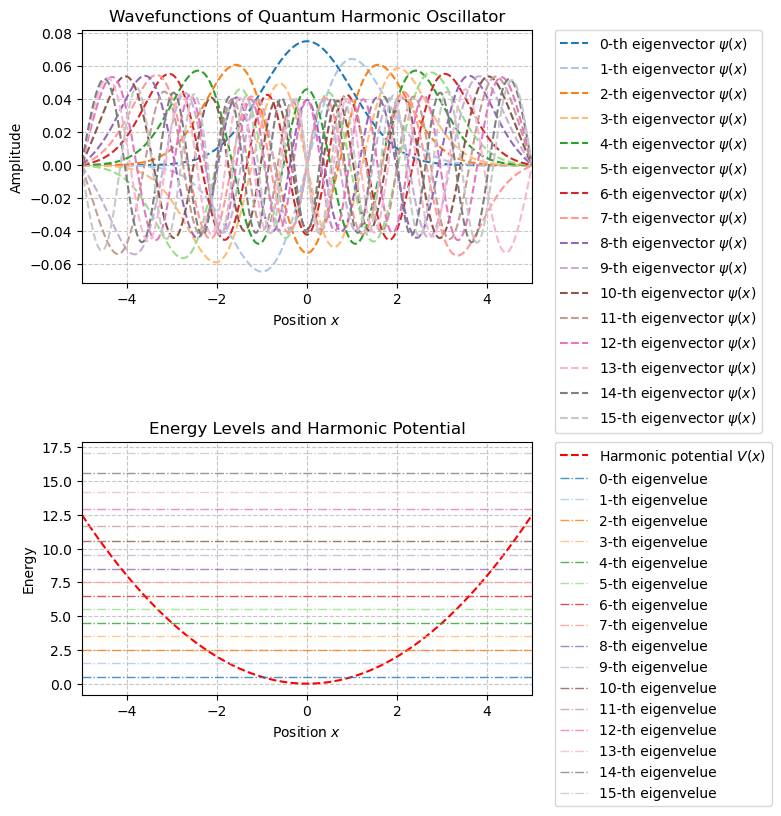

In [7]:
fu.plot(k, eigenvalues_order2, eigenvectors_order2, x_i, L, omega)

## Order 4

In [8]:
order = 4
A, eigenvalues_order4, eigenvectors_order4 = fu.hamiltonian_gen(N, deltax, x_i, omega, order)

eigenvalues_order4 = eigenvalues_order4[:k]
eigenvectors_order4 = eigenvectors_order4[:k]

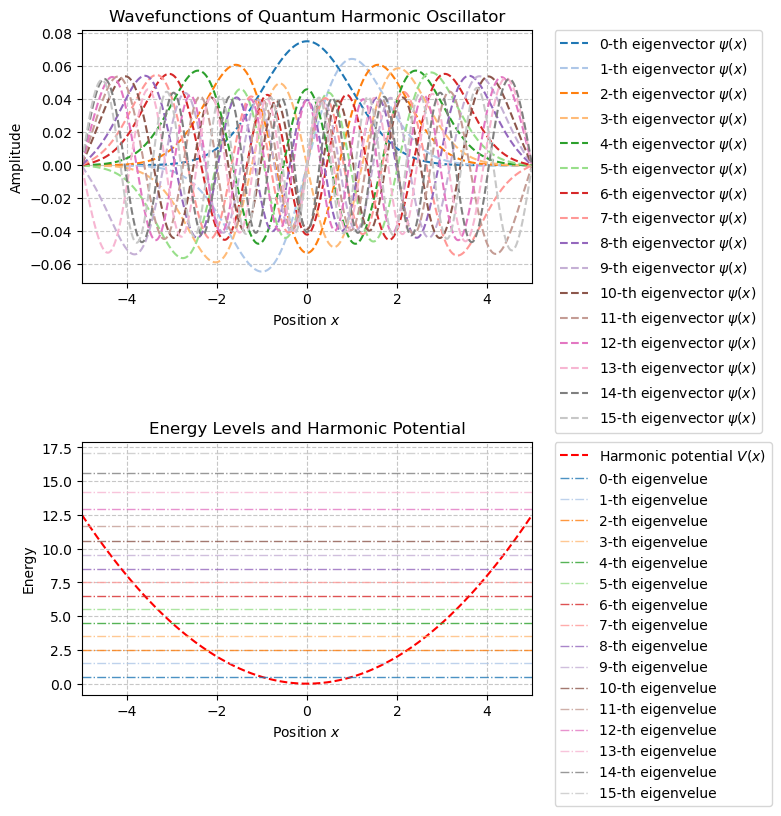

In [9]:
fu.plot(k, eigenvalues_order4, eigenvectors_order4, x_i, L, omega)

## Correctness

I first consider the correctness w.r.t. the order 2 

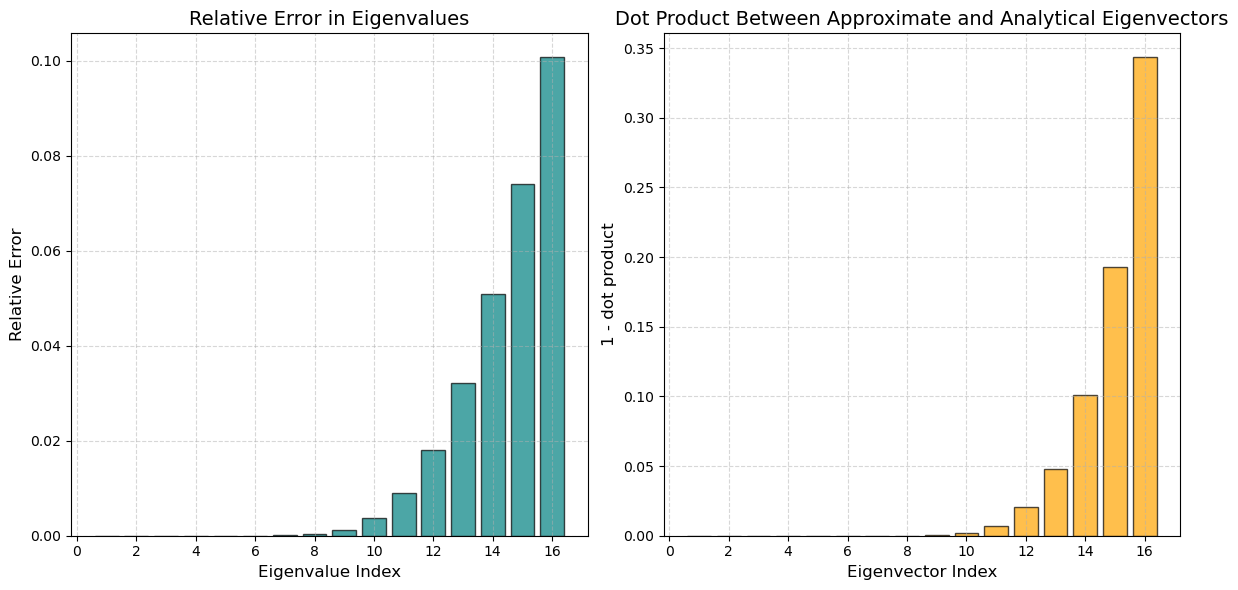

In [10]:
rel_eigval_err_order2, eigvec_dot_order2 = fu.correctness(k, eigenvalues_order2, eigenvectors_order2, eigenvalues_analy, eigenvectors_analy)

fu.plot_correctness(k, rel_eigval_err_order2, eigvec_dot_order2)

I then consider the correctness w.r.t. the degree 4

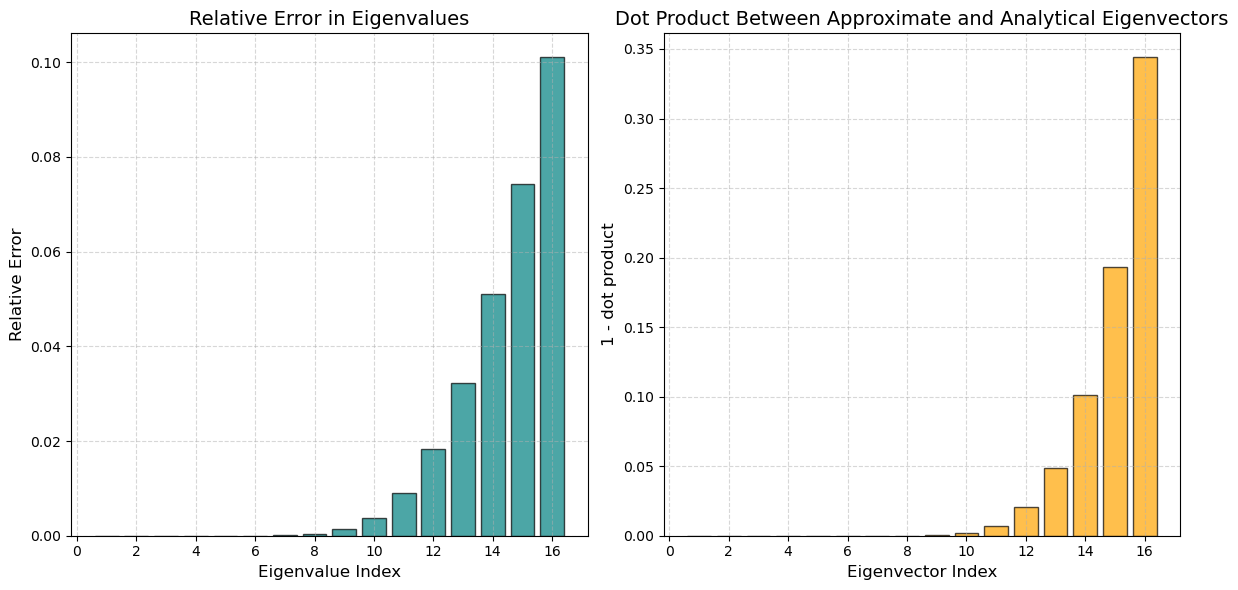

In [11]:
rel_eigval_err_order4, eigvec_dot_order4 = fu.correctness(k, eigenvalues_order4, eigenvectors_order4, eigenvalues_analy, eigenvectors_analy)

fu.plot_correctness(k, rel_eigval_err_order4, eigvec_dot_order4)

I plot in the same graph the 2 histograms in order to make a comparison

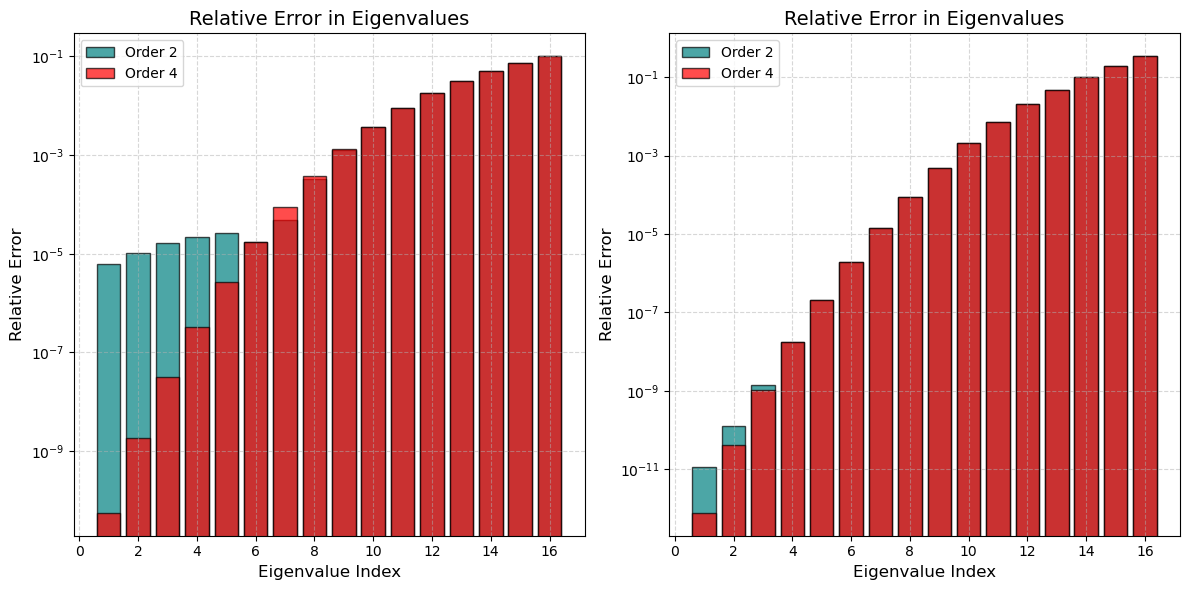

In [12]:
fu.plot_both_correctness(k, rel_eigval_err_order2, rel_eigval_err_order4, eigvec_dot_order2, eigvec_dot_order4)

## Stability

I start with order 2

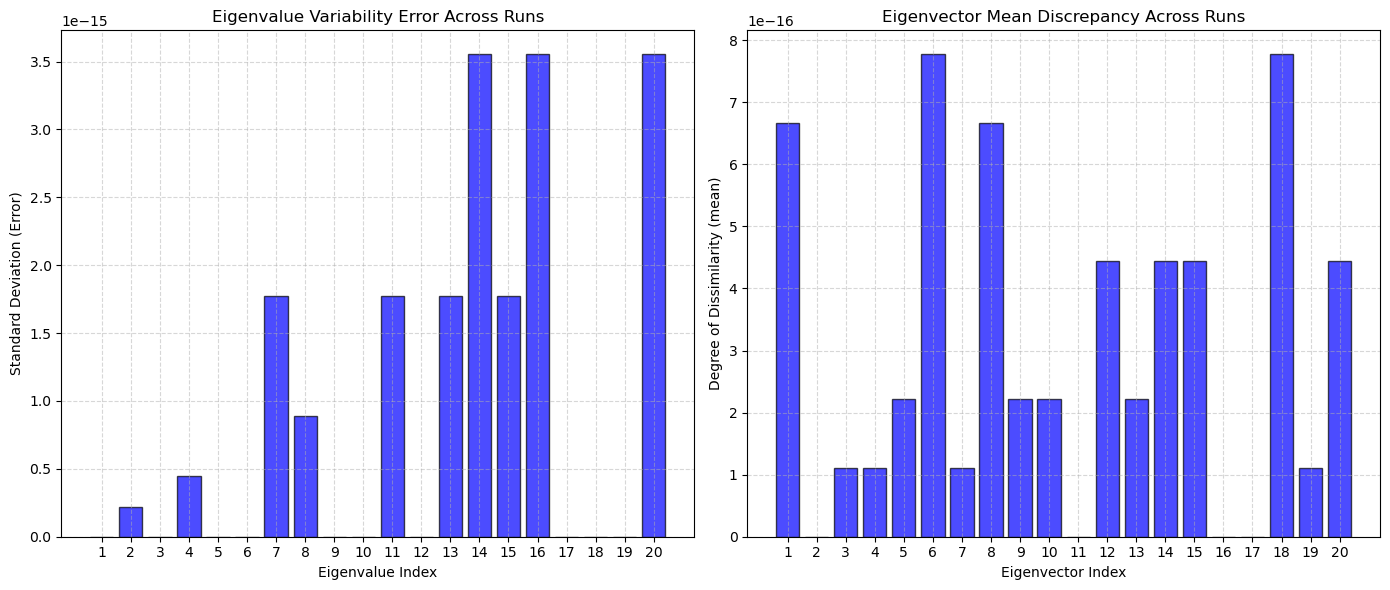

In [13]:
num_runs = 10
order = 2
k = 20

eigval_mean, eigval_std, dot_mat = fu.stability(num_runs, order, k, N, deltax, x_i, omega)

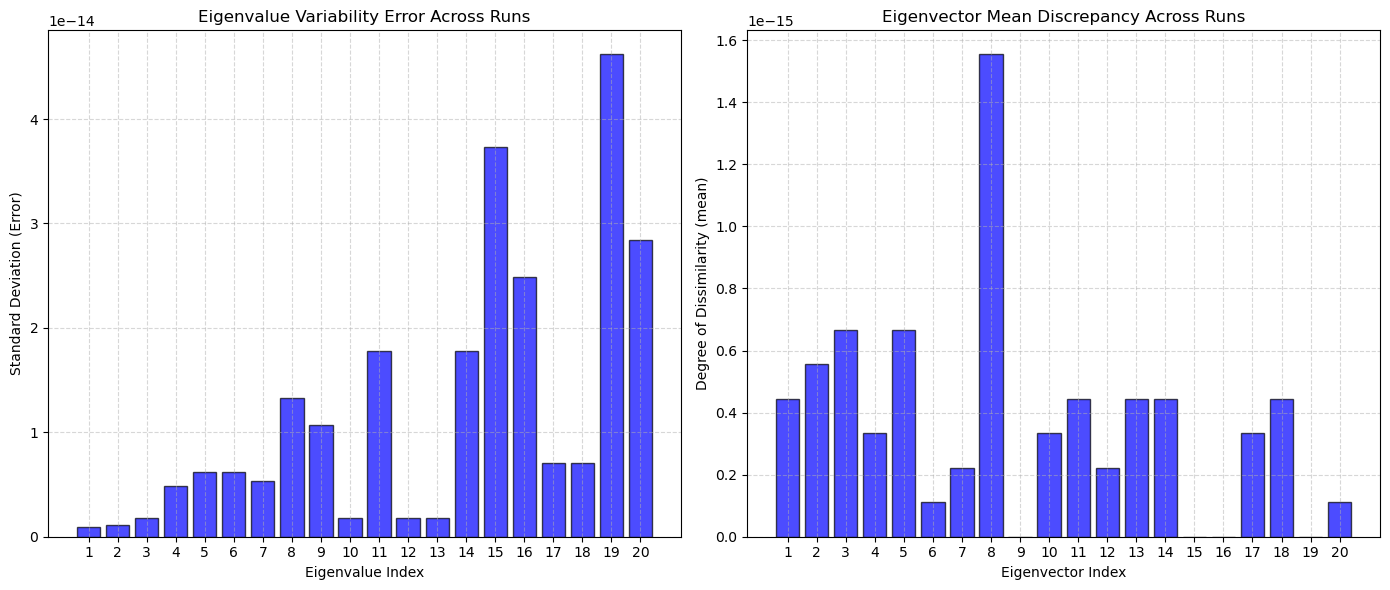

In [14]:
num_runs = 100
order = 4
k = 20

eigval_mean, eigval_std, dot_mat = fu.stability(num_runs, order, k, N, deltax, x_i, omega)

## Accurate Discretization

Here I would like to test the Accurate Discretization in terms of CORRECTNESS of the solutions.

### Order 2

In [15]:
step = 100
N_min = 100
N_max = 3000
k = 16  # Supponiamo di avere 16 autovalori/autovettori
order = 2
omega = 1

eigval_errors_matrix_2, eigvec_dots_matrix_2, sizes = fu.discretization_size(N_min, N_max, step, k, omega, L, order)

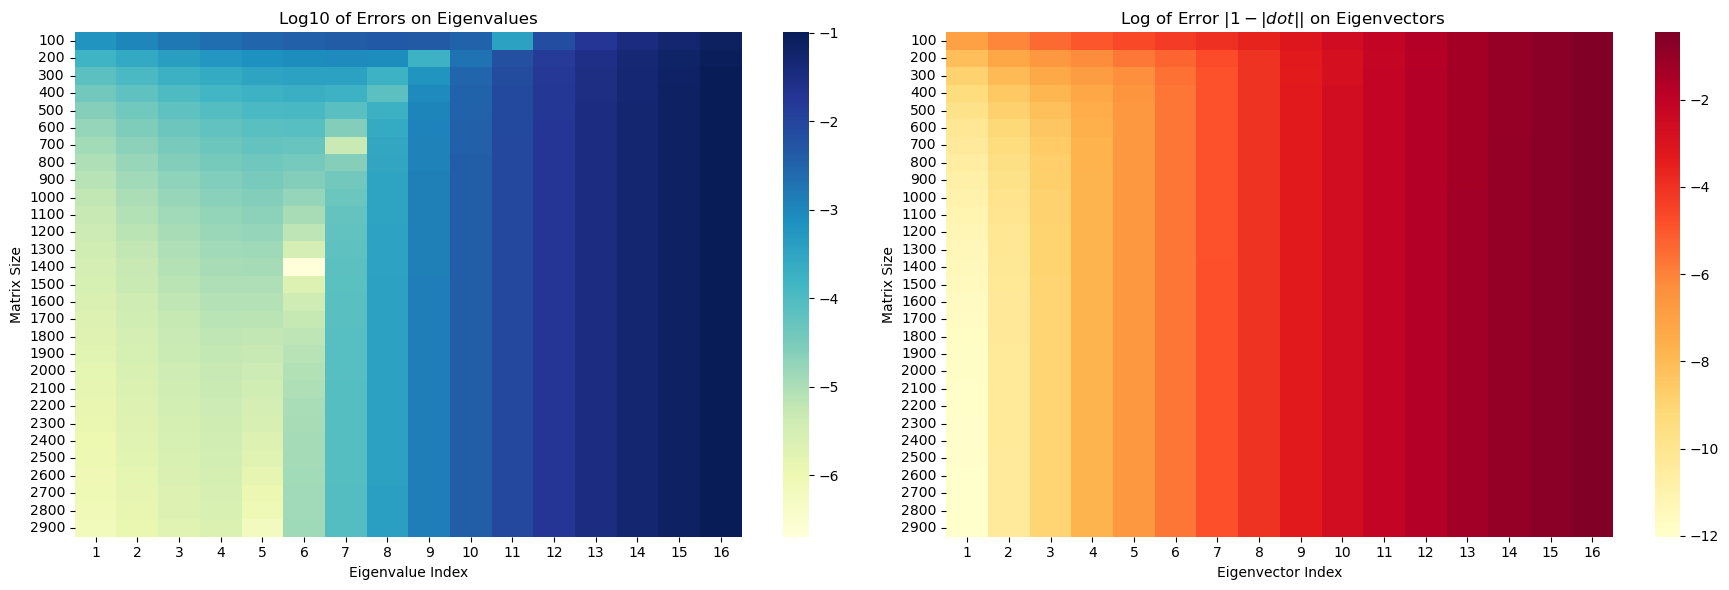

In [16]:
fu.scaling_heatmap(eigval_errors_matrix_2, eigvec_dots_matrix_2, sizes, k)

### Order 4 

In [17]:
step = 100
N_min = 100
N_max = 3000
k = 16  # Supponiamo di avere 16 autovalori/autovettori
order = 4
omega = 1

eigval_errors_matrix_4, eigvec_dots_matrix_4, sizes = fu.discretization_size(N_min, N_max, step, k, omega, L, order)

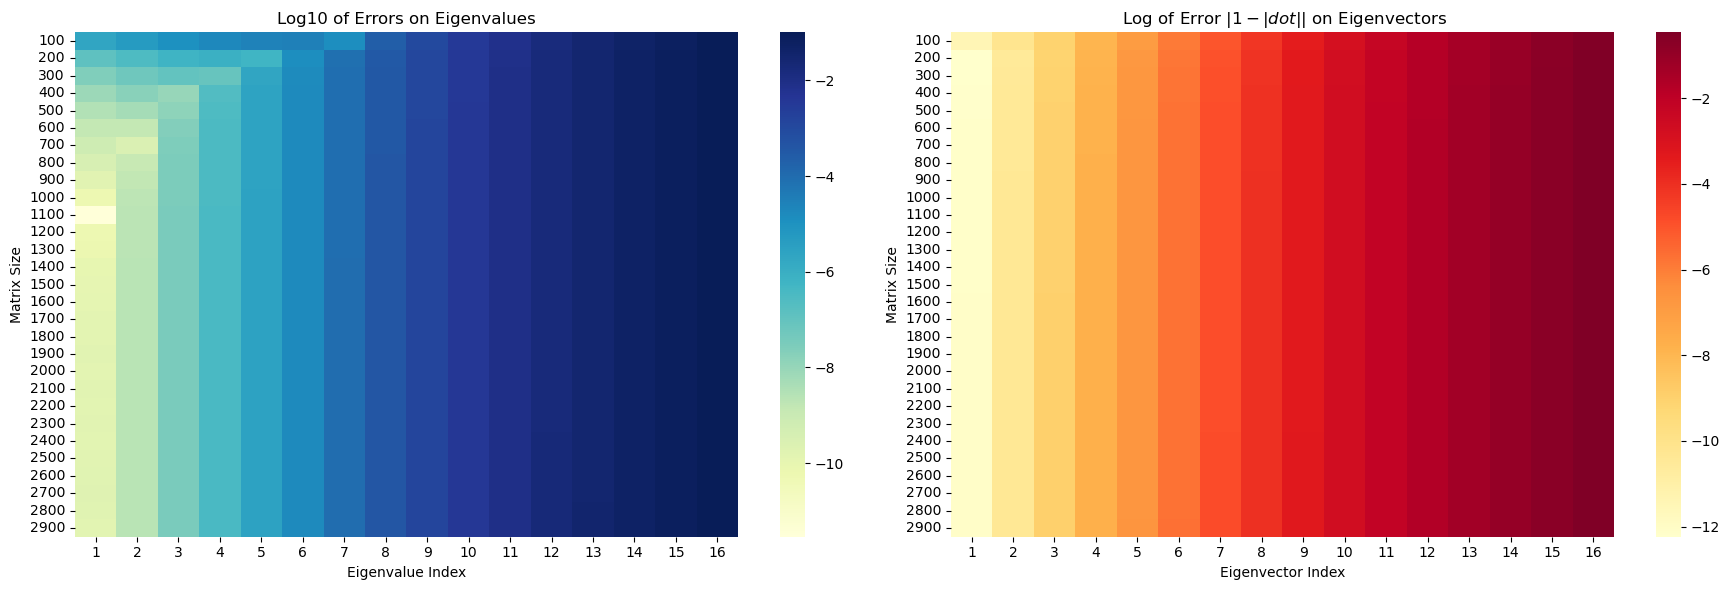

In [18]:
fu.scaling_heatmap(eigval_errors_matrix_4, eigvec_dots_matrix_4, sizes, k)

### Variation of Omega

Order 2

In [19]:
N = 1000
omega_step = 0.2
omega_min = 0.1
omega_max = 5.1
k = 16  # Supponiamo di avere 16 autovalori/autovettori
order = 2

eigval_errors_matrix_2, eigvec_dots_matrix_2, omega_sizes = fu.omega_variation(omega_min, omega_max, omega_step, k, N, L, order)

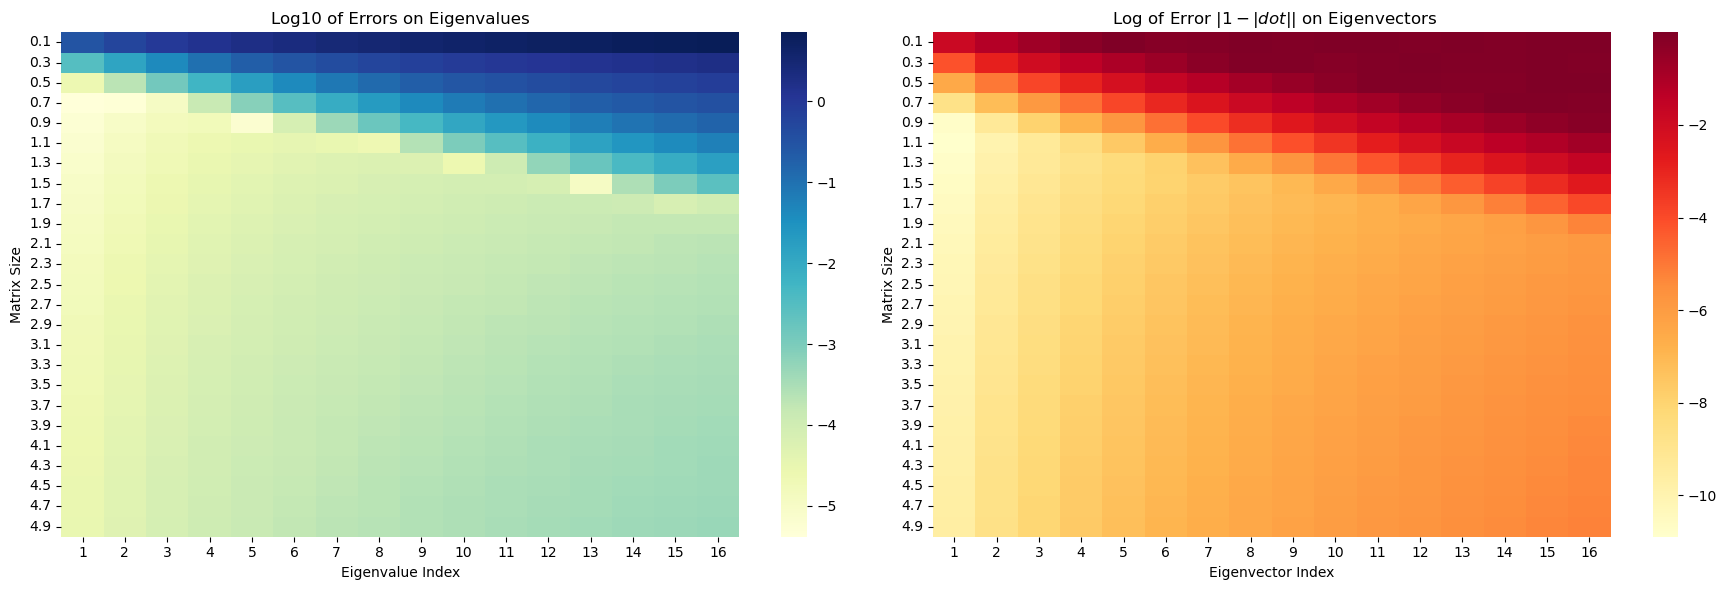

In [20]:
fu.scaling_heatmap(eigval_errors_matrix_2, eigvec_dots_matrix_2, omega_sizes, k)

Order 4

In [21]:
N = 1000
omega_step = 0.2
omega_min = 0.1
omega_max = 5.1
k = 16  # Supponiamo di avere 16 autovalori/autovettori
order = 4

eigval_errors_matrix_4, eigvec_dots_matrix_4, omega_sizes = fu.omega_variation(omega_min, omega_max, omega_step, k, N, L, order)

/home/sdruci/QIC/QIC/04_Assignement/functions.py:328: RuntimeWarning: divide by zero encountered in log10
  sns.heatmap(np.log10(eigvec_dots_matrix), ax=axes[1], annot=False, cmap="YlOrRd",
/home/sdruci/QIC/QIC/04_Assignement/functions.py:328: RuntimeWarning: invalid value encountered in log10
  sns.heatmap(np.log10(eigvec_dots_matrix), ax=axes[1], annot=False, cmap="YlOrRd",


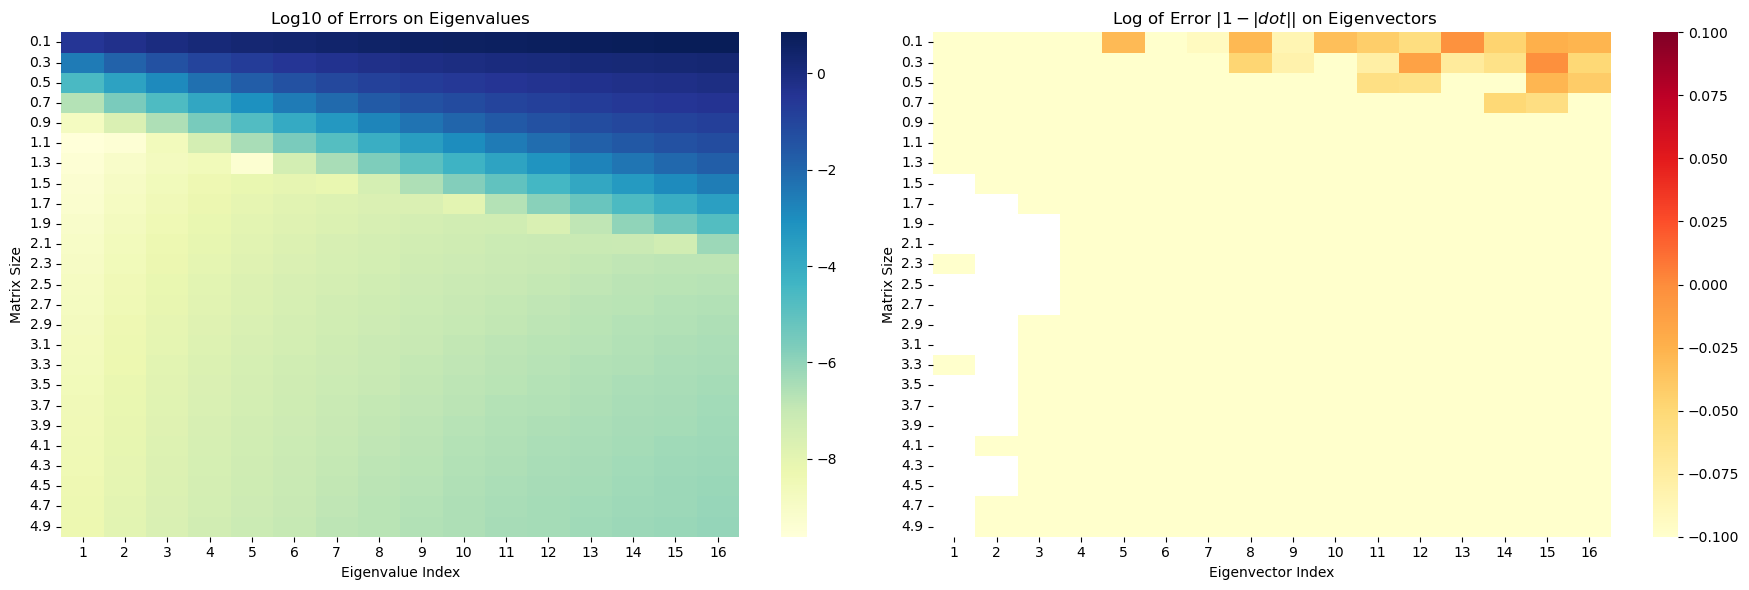

In [22]:
fu.scaling_heatmap(eigval_errors_matrix_4, eigvec_dots_matrix_4, omega_sizes, k)